In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20
import seaborn as sns
from fastaUtils.profiles import parse_profile,profile_data
from lbsNN import postprocess
from sklearn.decomposition import PCA
from umap import UMAP

tfk=tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

## Classes and helper functions

In [7]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [8]:
class AutoregressiveGenerate(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveGenerate, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.concat = tfkl.concatenate
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = tfd.OneHotCategorical(logits=x,dtype=tf.float32).sample()
    x = self.concat([input_tensor,x])
    return x

class AutoregressiveFit(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveFit, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.log_softmax = tf.nn.log_softmax
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = self.log_softmax(x)
    return x

def makeModelGenerate( cumwidth, makeCell ):
    In=tfkl.Input((cumwidth[1]))
    ar=AutoregressiveGenerate(makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"),name="col1")(In)
    for idx in range(3,len(cumwidth)):
        ar=AutoregressiveGenerate(makeCell(cumwidth[idx]-cumwidth[idx-1],name="col{}_cell".format(idx-1)),name="col{}".format(idx-1))(ar)
    return tfk.models.Model(In,ar)

def makeModelFit( cumwidth, makeCell ):
    In0=tfkl.Input((cumwidth[-1]))
    
    l0=In0[:,0:cumwidth[1]]
    l0=AutoregressiveFit( makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"), name="col1")(l0)
    for c in range(2,len(cumwidth)-1):
        l=In0[:,0:cumwidth[c]]
        l=AutoregressiveFit( makeCell(cumwidth[c+1]-cumwidth[c],name="col{}_cell".format(c)), name="col{}".format(c))(l)
        l0=tfkl.concatenate([l0,l])
    return tfk.models.Model(In0,l0)

lossFit=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1))

In [9]:
def decodeSequences(sequences,alphabet):
    q=len(alphabet)
    N=sequences.shape[1]//q
    decoded=[]
    for n in range(N):
        s=sequences[:,n*q:n*q+q]
        idx=np.argmax(s,axis=1)
        chars=[alphabet[i] for i in idx]
        decoded.append(chars)
    decoded=np.array(decoded,dtype='str').T
    sequences=[]
    for dec in decoded:
        sequences.append("".join(dec))
    return sequences

In [10]:
def getDCAParams( cumwidth, model ):
    W=np.zeros((cumwidth[-1],cumwidth[-1]))
    B=np.zeros((cumwidth[-1]))
    offset=cumwidth[1]
    for layer in model.layers:
        if layer.name[:3]=="col":
            w,b=layer.get_weights()
            W[0:w.shape[0],offset:offset+w.shape[1]]=w
            B[offset:offset+w.shape[1]]=b
            offset+=w.shape[1]
    return B,W

## Dataset and settings

In [11]:
dataset="datasets/jdm_A_ss3"
outbasename="jdm_A_ss3"

x=np.load("{dataset}.npy".format(dataset=dataset)).astype(float) # dataset
cumwidth=profile_data(parse_profile("{dataset}.profile".format(dataset=dataset))).cumulative

np.random.shuffle(x)
x=x[:10000]
Y=x[:,cumwidth[1]:]

epochs=5000
comparetodata=None
Ngen=10000
bs=1024 # batch size

if comparetodata is not None:
    xc=np.load(comparetodata).astype(float)

alphabet=list("-ACDEFGHIKLMNPQRSTVWY")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='min')
checkpoint=ModelCheckpoint("checkpoints/{}_weights".format(outbasename), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
reduce_lr=ReduceLROnPlateau(factor=0.2,patience=20,monitor='loss')
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.3,reload_weights=False)

In [12]:
from tensorflow.keras.regularizers import l2

def makeCell( outsize, name ):
    sequential=tfk.models.Sequential(name=name)
    sequential.add( tfkl.Dense(outsize,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear'))
    return sequential

## Models

In [13]:
generator=makeModelGenerate(cumwidth,makeCell)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
col1 (AutoregressiveGenerate (None, 5)                 9         
_________________________________________________________________
col2 (AutoregressiveGenerate (None, 9)                 24        
_________________________________________________________________
col3 (AutoregressiveGenerate (None, 13)                40        
_________________________________________________________________
col4 (AutoregressiveGenerate (None, 17)                56        
_________________________________________________________________
col5 (AutoregressiveGenerate (None, 21)                72        
_________________________________________________________________
col6 (AutoregressiveGenerate (None, 25)                88    

In [14]:
autoencoder=makeModelFit(cumwidth,makeCell)
autoencoder.compile(optimizer='sgd', loss=lossFit)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1175)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 2)            0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 5)            0           input_2[0][0]                    
__________________________________________________________________________________________________
col1 (AutoregressiveFit)        (None, 3)            9           tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

## Optimization of learning rate

Epoch 1/20
10/10 [==============================] - 11s 27ms/step - loss: 244.0551
Epoch 2/20
10/10 [==============================] - 0s 25ms/step - loss: 235.5193
Epoch 3/20
10/10 [==============================] - 0s 26ms/step - loss: 235.4779
Epoch 4/20
10/10 [==============================] - 0s 26ms/step - loss: 235.2488
Epoch 5/20
10/10 [==============================] - 0s 25ms/step - loss: 235.0579
Epoch 6/20
10/10 [==============================] - 0s 26ms/step - loss: 234.6127
Epoch 7/20
10/10 [==============================] - 0s 25ms/step - loss: 233.7221
Epoch 8/20
10/10 [==============================] - 0s 26ms/step - loss: 232.2429
Epoch 9/20
10/10 [==============================] - 0s 27ms/step - loss: 229.3229
Epoch 10/20
10/10 [==============================] - 0s 26ms/step - loss: 223.9238
Epoch 11/20
10/10 [==============================] - 0s 26ms/step - loss: 214.3812
Epoch 12/20
10/10 [==============================] - 0s 25ms/step - loss: 198.4091
Epoch 13/20


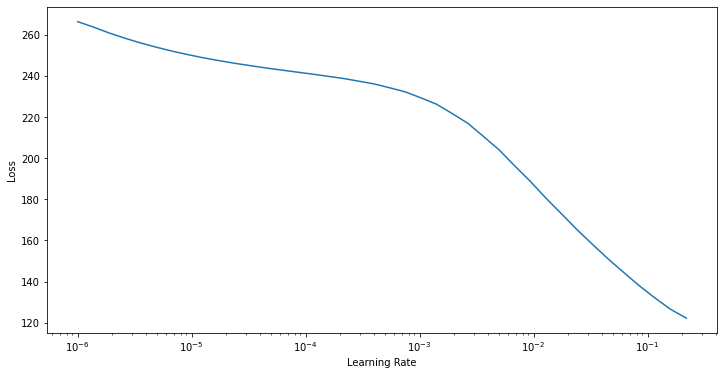

In [15]:
autoencoder.fit(x, Y, callbacks=[lr_finder,checkpoint], epochs=20, shuffle=True, batch_size=bs)

## Fitting

In [16]:
best_lr=1.e-1
optimizer=tf.keras.optimizers.SGD(lr=best_lr)
autoencoder.compile(optimizer=optimizer, loss=lossFit)

try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

hist=autoencoder.fit(x,Y,epochs=epochs,shuffle=True,callbacks=[earlystopping,checkpoint,reduce_lr], batch_size=bs)

Epoch 1/5000
10/10 [==============================] - 11s 28ms/step - loss: 77.2640
Epoch 2/5000
10/10 [==============================] - 0s 27ms/step - loss: 73.8922
Epoch 3/5000
10/10 [==============================] - 0s 26ms/step - loss: 70.4922
Epoch 4/5000
10/10 [==============================] - 0s 25ms/step - loss: 67.9119
Epoch 5/5000
10/10 [==============================] - 0s 26ms/step - loss: 65.5629
Epoch 6/5000
10/10 [==============================] - 0s 26ms/step - loss: 63.8559
Epoch 7/5000
10/10 [==============================] - 0s 26ms/step - loss: 62.9262
Epoch 8/5000
10/10 [==============================] - 0s 27ms/step - loss: 61.9472
Epoch 9/5000
10/10 [==============================] - 0s 26ms/step - loss: 60.7239
Epoch 10/5000
10/10 [==============================] - 0s 26ms/step - loss: 59.9522
Epoch 11/5000
10/10 [==============================] - 0s 26ms/step - loss: 59.4942
Epoch 12/5000
10/10 [==============================] - 0s 26ms/step - loss: 58.5575


10/10 [==============================] - 0s 25ms/step - loss: 47.4883
Epoch 99/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.1909
Epoch 100/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.3094
Epoch 101/5000
10/10 [==============================] - 0s 25ms/step - loss: 46.9797
Epoch 102/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.1624
Epoch 103/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.2029
Epoch 104/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.1180
Epoch 105/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.2327
Epoch 106/5000
10/10 [==============================] - 0s 25ms/step - loss: 46.9078
Epoch 107/5000
10/10 [==============================] - 0s 25ms/step - loss: 46.9576
Epoch 108/5000
10/10 [==============================] - 0s 25ms/step - loss: 47.1315
Epoch 109/5000
10/10 [==============================] - 0s 25ms/step - loss: 46.9

10/10 [==============================] - 0s 25ms/step - loss: 45.4441
Epoch 195/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.2264
Epoch 196/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.3987
Epoch 197/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.4939
Epoch 198/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.2266
Epoch 199/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.1453
Epoch 200/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.2391
Epoch 201/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.4041
Epoch 202/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.0161
Epoch 203/5000
10/10 [==============================] - 0s 26ms/step - loss: 45.0644
Epoch 204/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.1156
Epoch 205/5000
10/10 [==============================] - 0s 25ms/step - loss: 45.

10/10 [==============================] - 0s 25ms/step - loss: 44.3601
Epoch 291/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.5171
Epoch 292/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2655
Epoch 293/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.3115
Epoch 294/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2290
Epoch 295/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.3301
Epoch 296/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1430
Epoch 297/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2216
Epoch 298/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.3755
Epoch 299/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.3623
Epoch 300/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.4226
Epoch 301/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.

10/10 [==============================] - 0s 25ms/step - loss: 44.2917
Epoch 387/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2306
Epoch 388/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9809
Epoch 389/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2367
Epoch 390/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2348
Epoch 391/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2545
Epoch 392/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1280
Epoch 393/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2079
Epoch 394/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1530
Epoch 395/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.2986
Epoch 396/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1464
Epoch 397/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.

10/10 [==============================] - 0s 25ms/step - loss: 44.0282
Epoch 483/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1220
Epoch 484/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1428
Epoch 485/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0656
Epoch 486/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0518
Epoch 487/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9994
Epoch 488/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1615
Epoch 489/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9651
Epoch 490/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.1304
Epoch 491/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0355
Epoch 492/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0018
Epoch 493/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.

10/10 [==============================] - 0s 28ms/step - loss: 43.8142
Epoch 579/5000
10/10 [==============================] - 0s 27ms/step - loss: 43.9344
Epoch 580/5000
10/10 [==============================] - 0s 27ms/step - loss: 44.0098
Epoch 581/5000
10/10 [==============================] - 0s 27ms/step - loss: 44.1356
Epoch 582/5000
10/10 [==============================] - 0s 27ms/step - loss: 44.0353
Epoch 583/5000
10/10 [==============================] - 0s 27ms/step - loss: 43.8522
Epoch 584/5000
10/10 [==============================] - 0s 28ms/step - loss: 43.7569
Epoch 585/5000
10/10 [==============================] - 0s 27ms/step - loss: 44.1474
Epoch 586/5000
10/10 [==============================] - 0s 27ms/step - loss: 43.9392
Epoch 587/5000
10/10 [==============================] - 0s 28ms/step - loss: 43.9450
Epoch 588/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.8628
Epoch 589/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.

10/10 [==============================] - 0s 26ms/step - loss: 43.9008
Epoch 675/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8181
Epoch 676/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9483
Epoch 677/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9736
Epoch 678/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7185
Epoch 679/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0033
Epoch 680/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7059
Epoch 681/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8604
Epoch 682/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8392
Epoch 683/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7206
Epoch 684/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0836
Epoch 685/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.

10/10 [==============================] - 0s 25ms/step - loss: 43.7891
Epoch 771/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8530
Epoch 772/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7980
Epoch 773/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0613
Epoch 774/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.7996
Epoch 775/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8712
Epoch 776/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8445
Epoch 777/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9302
Epoch 778/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7780
Epoch 779/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0453
Epoch 780/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7481
Epoch 781/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.

10/10 [==============================] - 0s 25ms/step - loss: 43.8282
Epoch 867/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7684
Epoch 868/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6873
Epoch 869/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7743
Epoch 870/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.8421
Epoch 871/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8700
Epoch 872/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8006
Epoch 873/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7638
Epoch 874/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7361
Epoch 875/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6490
Epoch 876/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9121
Epoch 877/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.

10/10 [==============================] - 0s 25ms/step - loss: 43.7967
Epoch 963/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7974
Epoch 964/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5948
Epoch 965/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7893
Epoch 966/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9886
Epoch 967/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9281
Epoch 968/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.9044
Epoch 969/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7898
Epoch 970/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7921
Epoch 971/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7673
Epoch 972/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7516
Epoch 973/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.

10/10 [==============================] - 0s 25ms/step - loss: 43.7171
Epoch 1058/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7289
Epoch 1059/5000
10/10 [==============================] - 0s 25ms/step - loss: 44.0712
Epoch 1060/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6123
Epoch 1061/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7946
Epoch 1062/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4696
Epoch 1063/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8581
Epoch 1064/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7522
Epoch 1065/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5850
Epoch 1066/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7141
Epoch 1067/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6737
Epoch 1068/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.5581
Epoch 1153/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7519
Epoch 1154/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7771
Epoch 1155/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7388
Epoch 1156/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6498
Epoch 1157/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.8515
Epoch 1158/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5090
Epoch 1159/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6722
Epoch 1160/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4987
Epoch 1161/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7960
Epoch 1162/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6294
Epoch 1163/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.7774
Epoch 1248/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6901
Epoch 1249/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7322
Epoch 1250/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7755
Epoch 1251/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5142
Epoch 1252/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5184
Epoch 1253/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6355
Epoch 1254/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5526
Epoch 1255/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.6506
Epoch 1256/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6766
Epoch 1257/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7196
Epoch 1258/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.5545
Epoch 1343/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5956
Epoch 1344/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.6491
Epoch 1345/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4892
Epoch 1346/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6307
Epoch 1347/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7402
Epoch 1348/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5937
Epoch 1349/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5371
Epoch 1350/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4098
Epoch 1351/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5643
Epoch 1352/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6102
Epoch 1353/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.6193
Epoch 1438/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4415
Epoch 1439/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5596
Epoch 1440/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5979
Epoch 1441/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6008
Epoch 1442/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3899
Epoch 1443/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6772
Epoch 1444/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6111
Epoch 1445/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5528
Epoch 1446/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3343
Epoch 1447/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4983
Epoch 1448/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4616
Epoch 1533/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3789
Epoch 1534/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7746
Epoch 1535/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3925
Epoch 1536/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5052
Epoch 1537/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5405
Epoch 1538/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5501
Epoch 1539/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5679
Epoch 1540/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3704
Epoch 1541/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5984
Epoch 1542/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6592
Epoch 1543/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.3787
Epoch 1628/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5886
Epoch 1629/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.4088
Epoch 1630/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5581
Epoch 1631/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3014
Epoch 1632/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4376
Epoch 1633/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4196
Epoch 1634/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7163
Epoch 1635/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4889
Epoch 1636/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4171
Epoch 1637/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3683
Epoch 1638/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 26ms/step - loss: 43.5860
Epoch 1723/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5742
Epoch 1724/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4017
Epoch 1725/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6368
Epoch 1726/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4233
Epoch 1727/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4153
Epoch 1728/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4815
Epoch 1729/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4735
Epoch 1730/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3829
Epoch 1731/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5924
Epoch 1732/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4809
Epoch 1733/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.6240
Epoch 1818/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4216
Epoch 1819/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4381
Epoch 1820/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2573
Epoch 1821/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5982
Epoch 1822/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4874
Epoch 1823/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5051
Epoch 1824/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4903
Epoch 1825/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3956
Epoch 1826/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5606
Epoch 1827/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7482
Epoch 1828/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4394
Epoch 1913/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4198
Epoch 1914/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4084
Epoch 1915/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3447
Epoch 1916/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3549
Epoch 1917/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4513
Epoch 1918/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3752
Epoch 1919/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3537
Epoch 1920/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6016
Epoch 1921/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3942
Epoch 1922/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3448
Epoch 1923/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4722
Epoch 2008/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5517
Epoch 2009/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3501
Epoch 2010/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4770
Epoch 2011/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4866
Epoch 2012/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4720
Epoch 2013/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7142
Epoch 2014/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5064
Epoch 2015/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4863
Epoch 2016/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5156
Epoch 2017/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4258
Epoch 2018/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4417
Epoch 2103/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5020
Epoch 2104/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6379
Epoch 2105/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5975
Epoch 2106/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3960
Epoch 2107/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5212
Epoch 2108/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2371
Epoch 2109/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4934
Epoch 2110/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4422
Epoch 2111/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3612
Epoch 2112/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3637
Epoch 2113/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4520
Epoch 2198/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5506
Epoch 2199/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4004
Epoch 2200/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4047
Epoch 2201/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5900
Epoch 2202/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5769
Epoch 2203/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5499
Epoch 2204/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4437
Epoch 2205/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4514
Epoch 2206/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3903
Epoch 2207/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4633
Epoch 2208/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.5865
Epoch 2293/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3309
Epoch 2294/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4099
Epoch 2295/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4425
Epoch 2296/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4807
Epoch 2297/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5472
Epoch 2298/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4195
Epoch 2299/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5252
Epoch 2300/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2116
Epoch 2301/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3318
Epoch 2302/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5020
Epoch 2303/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.3872
Epoch 2388/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3188
Epoch 2389/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4194
Epoch 2390/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.7647
Epoch 2391/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4491
Epoch 2392/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4392
Epoch 2393/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3618
Epoch 2394/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3168
Epoch 2395/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6040
Epoch 2396/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4228
Epoch 2397/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2734
Epoch 2398/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.1195
Epoch 2483/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4812
Epoch 2484/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4000
Epoch 2485/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6235
Epoch 2486/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.1884
Epoch 2487/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3390
Epoch 2488/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6204
Epoch 2489/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2890
Epoch 2490/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4551
Epoch 2491/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4040
Epoch 2492/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3897
Epoch 2493/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 26ms/step - loss: 43.3616
Epoch 2578/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3456
Epoch 2579/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4222
Epoch 2580/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4544
Epoch 2581/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2010
Epoch 2582/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4036
Epoch 2583/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2707
Epoch 2584/5000
10/10 [==============================] - 0s 26ms/step - loss: 43.4651
Epoch 2585/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3238
Epoch 2586/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4721
Epoch 2587/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3159
Epoch 2588/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.3707
Epoch 2673/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2766
Epoch 2674/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4134
Epoch 2675/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.1382
Epoch 2676/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.6016
Epoch 2677/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5320
Epoch 2678/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4221
Epoch 2679/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4477
Epoch 2680/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5727
Epoch 2681/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5828
Epoch 2682/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2120
Epoch 2683/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4100
Epoch 2768/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3589
Epoch 2769/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4850
Epoch 2770/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2682
Epoch 2771/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3767
Epoch 2772/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4454
Epoch 2773/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3528
Epoch 2774/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4243
Epoch 2775/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5875
Epoch 2776/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3268
Epoch 2777/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4329
Epoch 2778/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.1551
Epoch 2863/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3989
Epoch 2864/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3895
Epoch 2865/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4166
Epoch 2866/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2766
Epoch 2867/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4315
Epoch 2868/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3643
Epoch 2869/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2198
Epoch 2870/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4535
Epoch 2871/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2002
Epoch 2872/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.5943
Epoch 2873/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.0781
Epoch 2958/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4437
Epoch 2959/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3943
Epoch 2960/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2796
Epoch 2961/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4719
Epoch 2962/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3358
Epoch 2963/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3233
Epoch 2964/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2767
Epoch 2965/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2374
Epoch 2966/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.1819
Epoch 2967/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.1647
Epoch 2968/5000
10/10 [==============================] - 0s 25ms/step 

10/10 [==============================] - 0s 25ms/step - loss: 43.4607
Epoch 3053/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4325
Epoch 3054/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2440
Epoch 3055/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4388
Epoch 3056/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3790
Epoch 3057/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3091
Epoch 3058/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4088
Epoch 3059/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.4756
Epoch 3060/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3598
Epoch 3061/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.3133
Epoch 3062/5000
10/10 [==============================] - 0s 25ms/step - loss: 43.2020
Epoch 3063/5000
10/10 [==============================] - 0s 25ms/step 

In [17]:
try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

autoencoder.save_weights("checkpoints/{}_weights".format(outbasename))
generator.load_weights("checkpoints/{}_weights".format(outbasename))


Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5ae21e2f70> and <__main__.AutoregressiveGenerate object at 0x7f5a0007a190>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5ae21e2f70> and <__main__.AutoregressiveGenerate object at 0x7f5a0007a190>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a000e8550> and <__main__.AutoregressiveGenerate object at 0x7f5a000c1d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a000e8550> and <__main__.AutoregressiveGenerate object at 0x7f5a000c1d00>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a0007a190> and <__main__.AutoregressiveGenerate object at 0x7f5a1ee05d60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a0007a190> and <__main__.AutoregressiveGenerate object at 0x7f5a1ee05d60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a000c1d00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f6fb4f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a000c1d00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f6fb4f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a0008ea00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7e5940>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a0008ea00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7e5940>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ee54940> and <__main__.AutoregressiveGenerate object at 0x7f5a1edd02e0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ee54940> and <__main__.AutoregressiveGenerate object at 0x7f5a1edd02e0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ee05d60> and <__main__.AutoregressiveGenerate object at 0x7f5a1f890f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ee05d60> and <__main__.AutoregressiveGenerate object at 0x7f5a1f890f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af190> and <__main__.AutoregressiveGenerate object at 0x7f5a1f40da30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af190> and <__main__.AutoregressiveGenerate object at 0x7f5a1f40da30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f13fa00> and <__main__.AutoregressiveGenerate object at 0x7f5a1fad2fa0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f13fa00> and <__main__.AutoregressiveGenerate object at 0x7f5a1fad2fa0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6fb4f0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2369d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6fb4f0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2369d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f12c400> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2eb0d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f12c400> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2eb0d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6a8190> and <__main__.AutoregressiveGenerate object at 0x7f5a1f548be0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6a8190> and <__main__.AutoregressiveGenerate object at 0x7f5a1f548be0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f7e5940> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4cb580>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f7e5940> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4cb580>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f585040> and <__main__.AutoregressiveGenerate object at 0x7f5a1f445e20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f585040> and <__main__.AutoregressiveGenerate object at 0x7f5a1f445e20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ef0c190> and <__main__.AutoregressiveGenerate object at 0x7f5a200ea5b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ef0c190> and <__main__.AutoregressiveGenerate object at 0x7f5a200ea5b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1edd02e0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f39a3a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1edd02e0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f39a3a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f8ef760> and <__main__.AutoregressiveGenerate object at 0x7f5a1f38a6a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f8ef760> and <__main__.AutoregressiveGenerate object at 0x7f5a1f38a6a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f707850> and <__main__.AutoregressiveGenerate object at 0x7f5a1f44ed90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f707850> and <__main__.AutoregressiveGenerate object at 0x7f5a1f44ed90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f890f40> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4d4d90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f890f40> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4d4d90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1efe27f0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2e6bb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1efe27f0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f2e6bb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f717460> and <__main__.AutoregressiveGenerate object at 0x7f5a1f5ae070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f717460> and <__main__.AutoregressiveGenerate object at 0x7f5a1f5ae070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f40da30> and <__main__.AutoregressiveGenerate object at 0x7f5a1fac7fd0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f40da30> and <__main__.AutoregressiveGenerate object at 0x7f5a1fac7fd0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6b7be0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f37b760>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6b7be0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f37b760>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af3d0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fe89790>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af3d0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fe89790>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1fad2fa0> and <__main__.AutoregressiveGenerate object at 0x7f5a20139070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1fad2fa0> and <__main__.AutoregressiveGenerate object at 0x7f5a20139070>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f938ee0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4d4910>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f938ee0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4d4910>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f282730> and <__main__.AutoregressiveGenerate object at 0x7f5a1f9490a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f282730> and <__main__.AutoregressiveGenerate object at 0x7f5a1f9490a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f2369d0> and <__main__.AutoregressiveGenerate object at 0x7f5a201b0850>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f2369d0> and <__main__.AutoregressiveGenerate object at 0x7f5a201b0850>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f3f5a00> and <__main__.AutoregressiveGenerate object at 0x7f5a217615b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f3f5a00> and <__main__.AutoregressiveGenerate object at 0x7f5a217615b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f46cbe0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fd4f940>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f46cbe0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fd4f940>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f2eb0d0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7aa280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f2eb0d0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7aa280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ff1e130> and <__main__.AutoregressiveGenerate object at 0x7f5a1fd4fbb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1ff1e130> and <__main__.AutoregressiveGenerate object at 0x7f5a1fd4fbb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6b7190> and <__main__.AutoregressiveGenerate object at 0x7f5a1fb9fca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f6b7190> and <__main__.AutoregressiveGenerate object at 0x7f5a1fb9fca0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f548be0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f78ba30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f548be0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f78ba30>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f41f580> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4ef460>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f41f580> and <__main__.AutoregressiveGenerate object at 0x7f5a1f4ef460>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f53e280> and <__main__.AutoregressiveGenerate object at 0x7f5a1ff3f970>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f53e280> and <__main__.AutoregressiveGenerate object at 0x7f5a1ff3f970>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4cb580> and <__main__.AutoregressiveGenerate object at 0x7f5a1fbd62b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4cb580> and <__main__.AutoregressiveGenerate object at 0x7f5a1fbd62b0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4be760> and <__main__.AutoregressiveGenerate object at 0x7f5a1fcf8e50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4be760> and <__main__.AutoregressiveGenerate object at 0x7f5a1fcf8e50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4e54c0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fbfa280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f4e54c0> and <__main__.AutoregressiveGenerate object at 0x7f5a1fbfa280>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f445e20> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7d20a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f445e20> and <__main__.AutoregressiveGenerate object at 0x7f5a1f7d20a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af9a0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f9b6e50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f5af9a0> and <__main__.AutoregressiveGenerate object at 0x7f5a1f9b6e50>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f942a00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f33c1c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f5a1f942a00> and <__main__.AutoregressiveGenerate object at 0x7f5a1f33c1c0>).


## Standard DCA analysis

In [29]:
h,J=getDCAParams( cumwidth, generator )
J=(J+J.T)/2
hig,Jig=postprocess.ising_gauge([h,J],cumwidth,cumwidth)
S=postprocess.norm_score(Jig,cumwidth,cumwidth)
Sapc=postprocess.apc(S)
Sapc=Sapc[Sapc.shape[0]//2:,Sapc.shape[0]//2:]

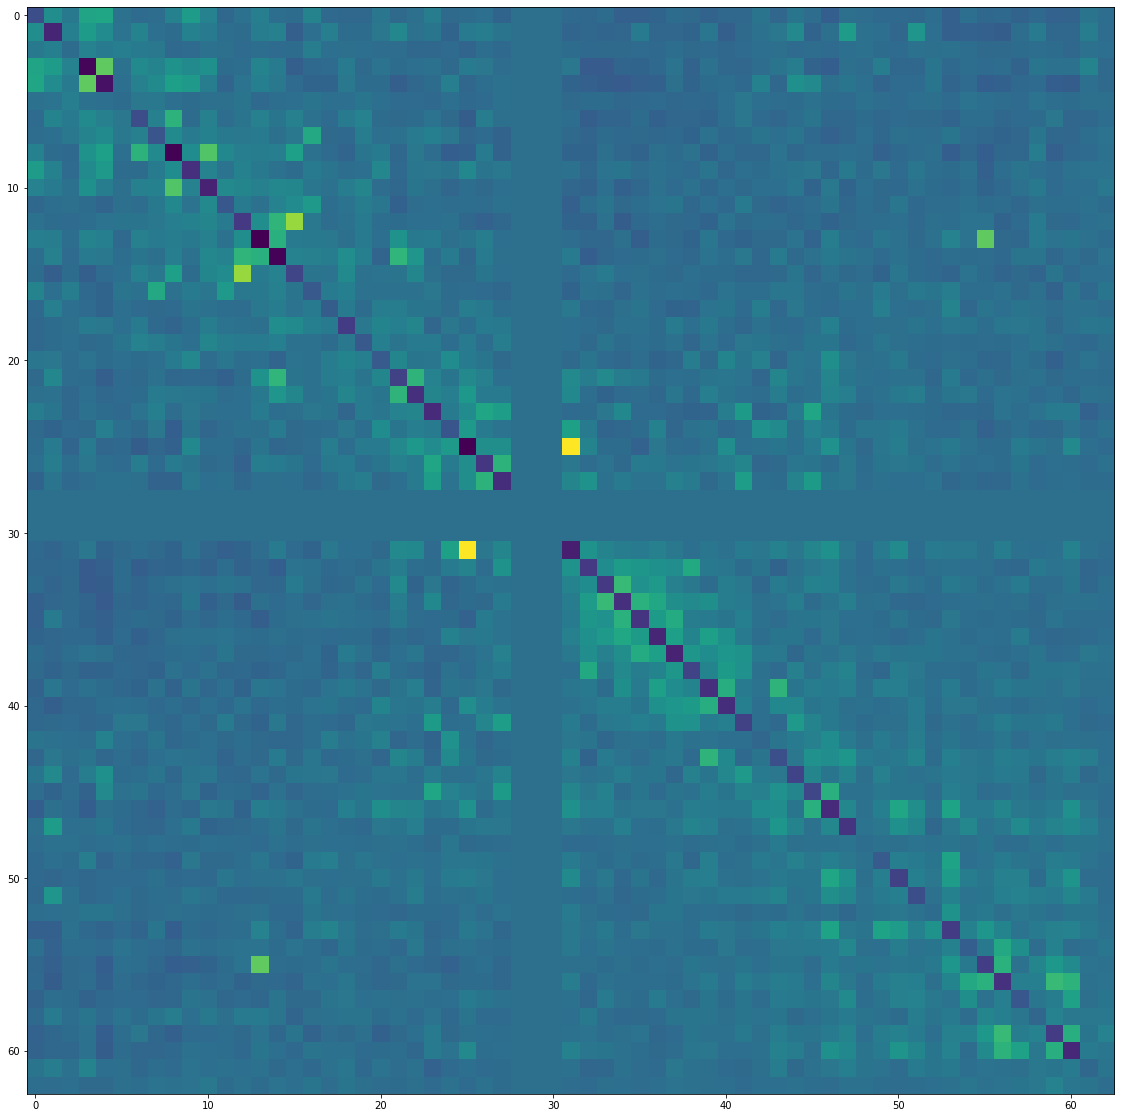

In [30]:
plt.imshow(Sapc)

## Generate sequences

In [31]:
p0=x[:,cumwidth[0]:cumwidth[1]].mean(axis=0)
P0=np.broadcast_to(p0,(Ngen,p0.shape[0]))
A0=tfd.OneHotCategorical(probs=P0).sample()
s=generator.predict(A0)
ss=decodeSequences(s,list("-ACDEFGHIKLMNPQRSTVWY"))

## Performance: frequencies

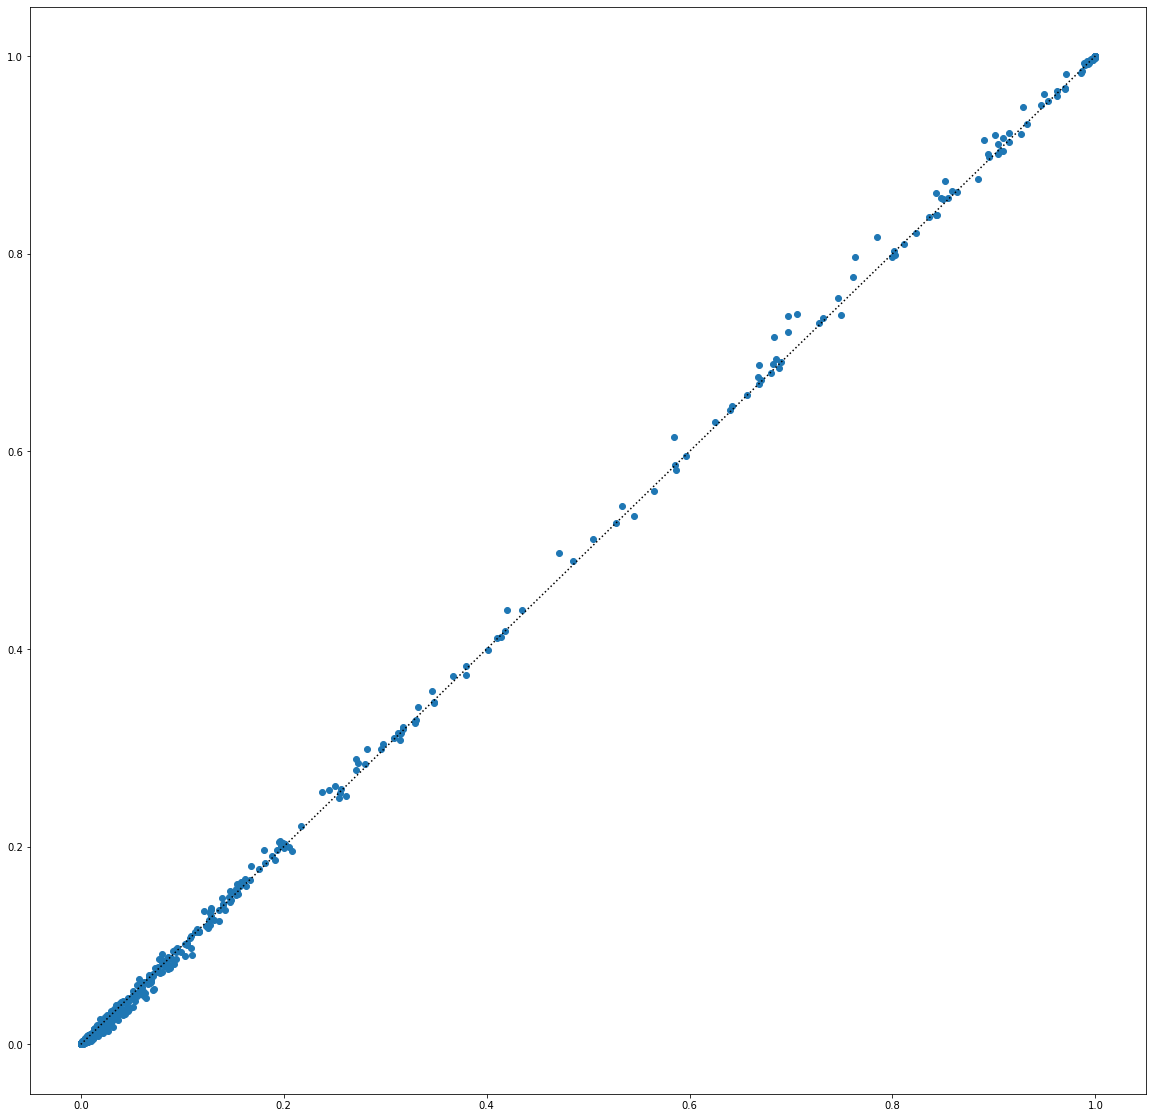

In [32]:
px=x.mean(axis=0)
pg=s.mean(axis=0)
plt.scatter(px,pg)
plt.plot([np.min(px),np.max(px)],[np.min(px),np.max(px)],c='black',linestyle=':')

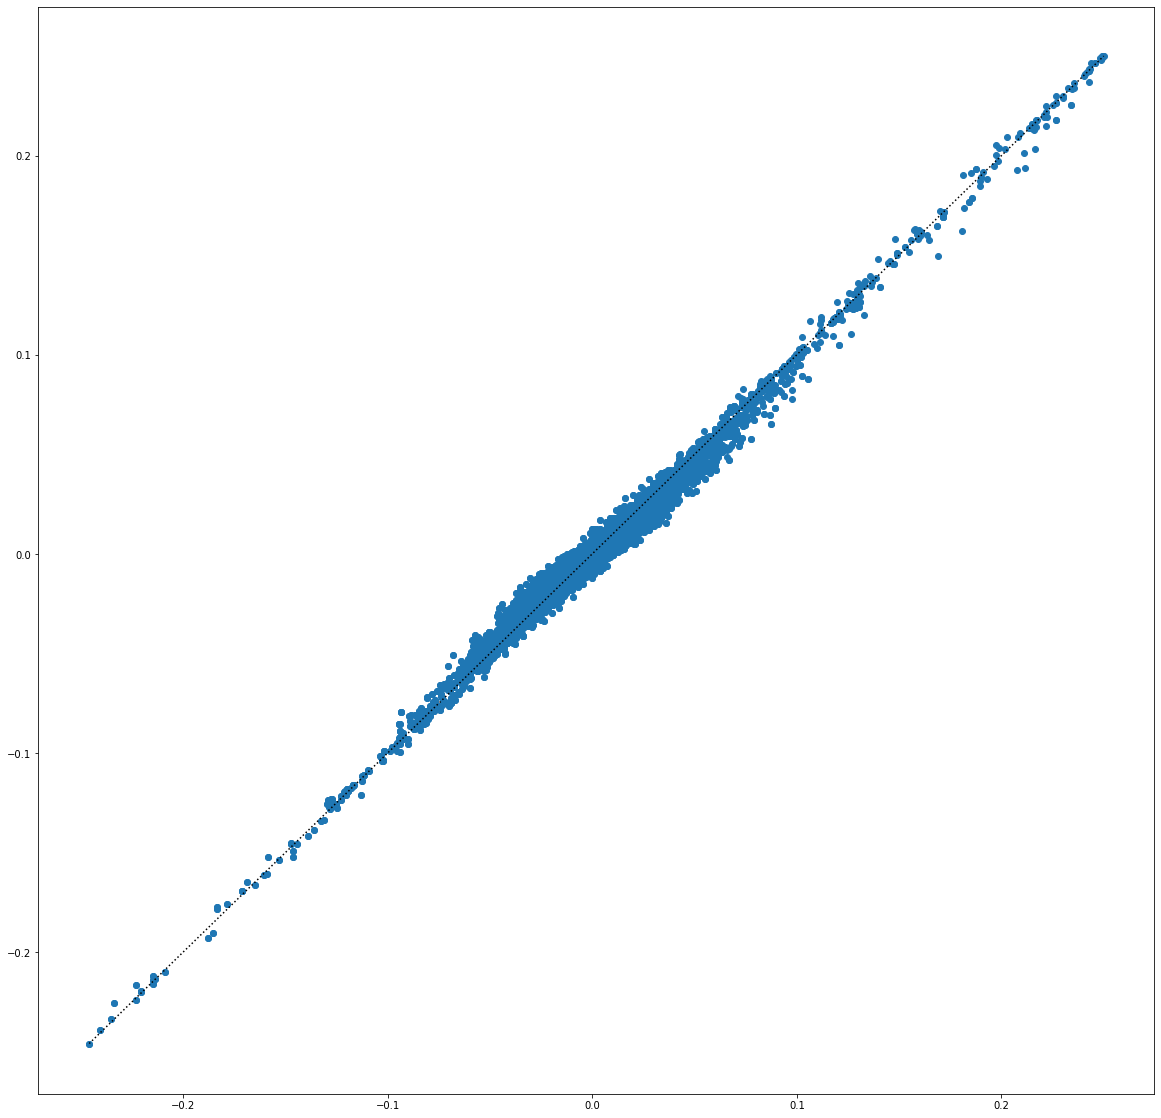

In [33]:
ppx=(np.matmul(x.T,x)/x.shape[0]-np.multiply(px[np.newaxis,:],px[:,np.newaxis])).flatten()
ppg=(np.matmul(s.T,s)/s.shape[0]-np.multiply(pg[np.newaxis,:],pg[:,np.newaxis])).flatten()
plt.scatter(ppx,ppg)
plt.plot([np.min(ppx),np.max(ppx)],[np.min(ppx),np.max(ppx)],c='black',linestyle=':')

## Performance: PCA

In [34]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(n_components=2)

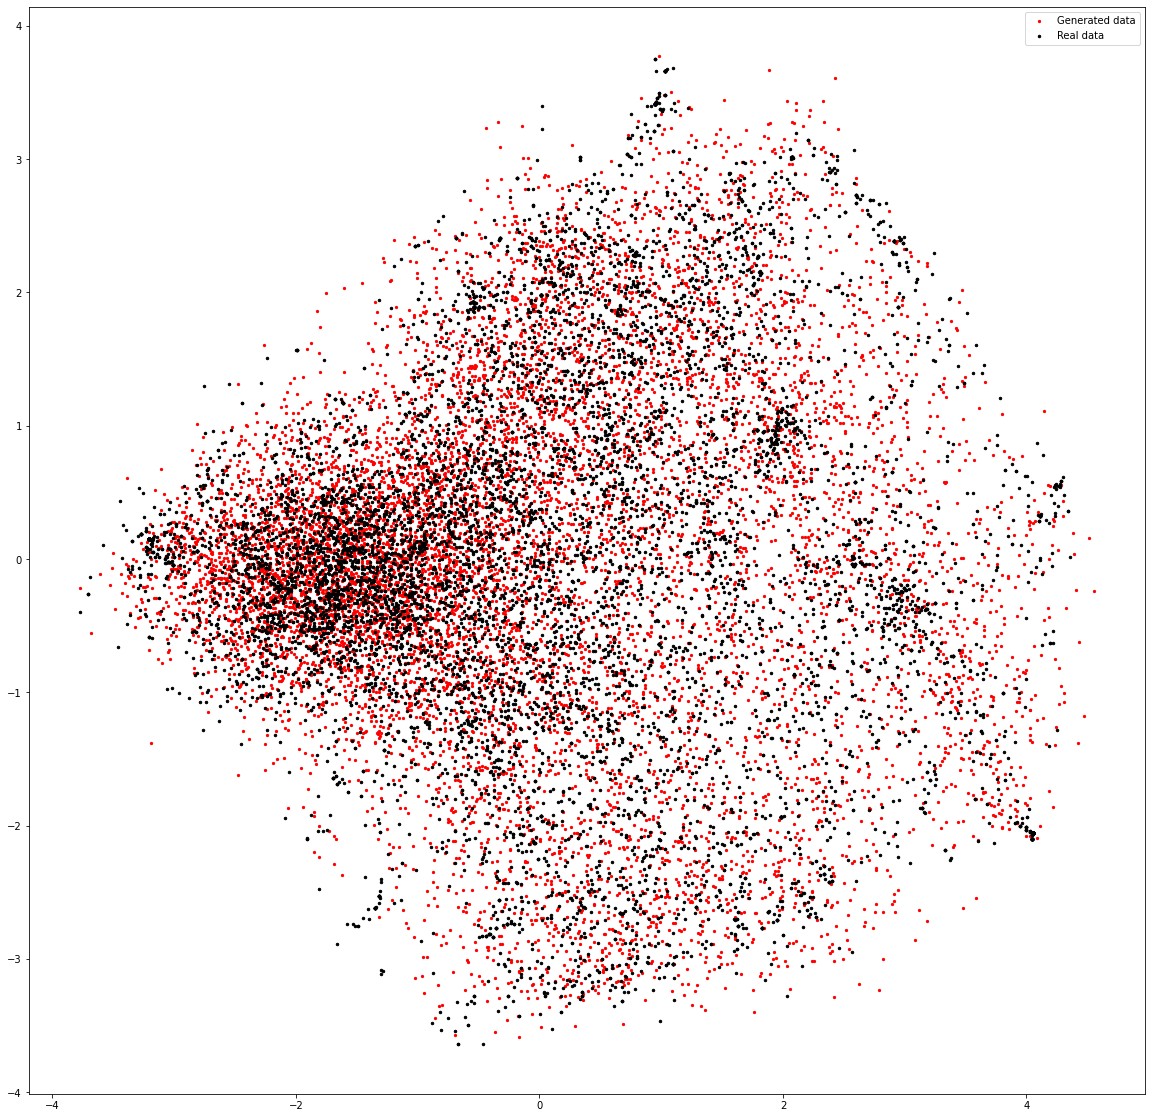

In [35]:
xpca=pca.transform(x)
gpca=pca.transform(s)
if comparetodata is not None:
    xcpca=pca.transform(xc)

plt.scatter(gpca[:,0],gpca[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcpca[:,0],xcpca[:,1], c='green',label='Other method')
plt.scatter(xpca[:,0],xpca[:,1], s=6, c='black',label='Real data')
plt.legend()

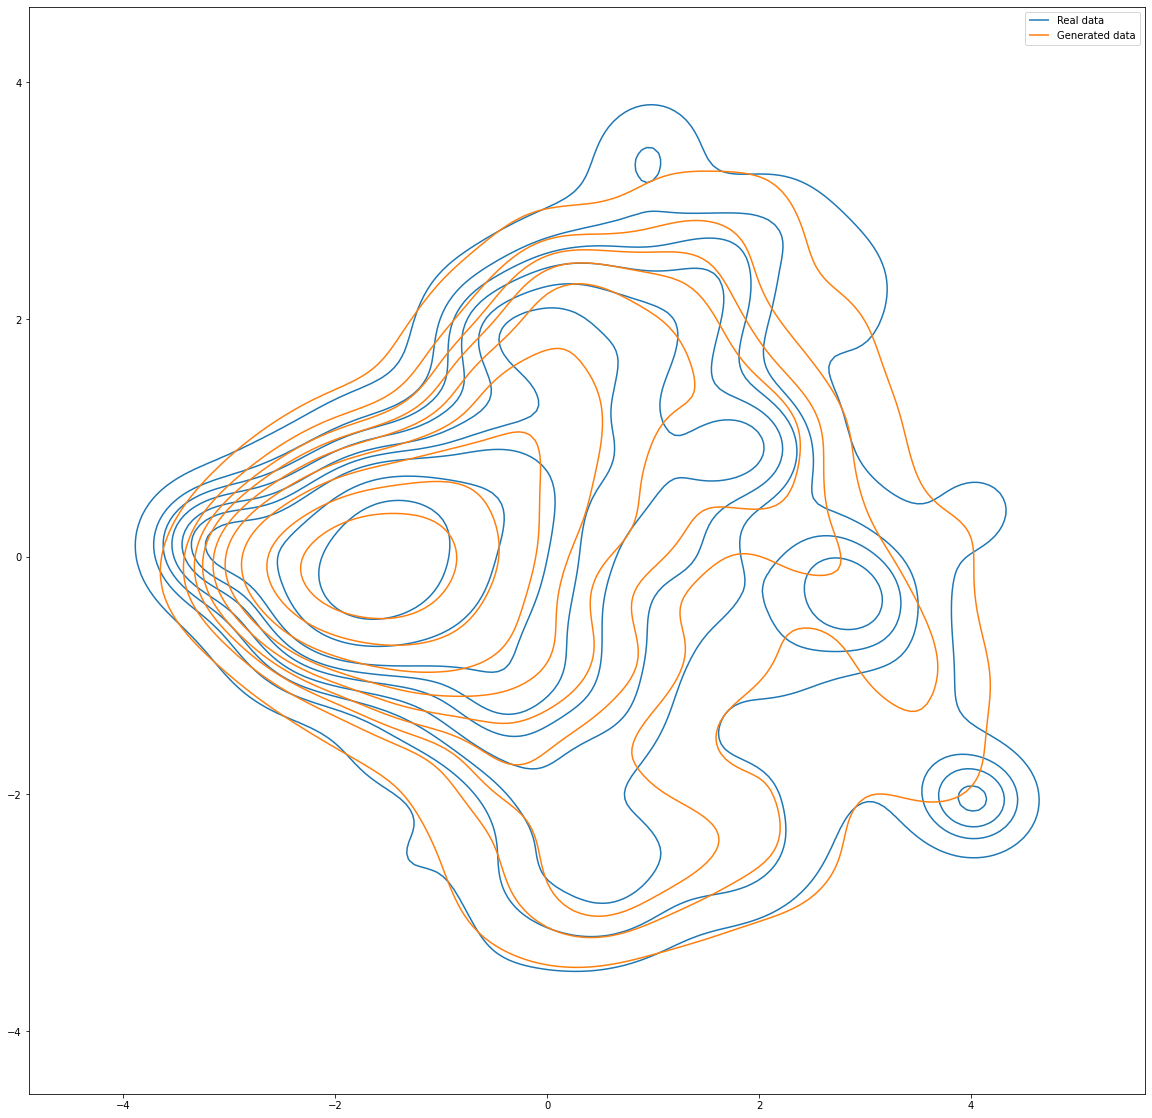

In [36]:
sns.kdeplot(x=xpca[:,0], y=xpca[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gpca[:,0], y=gpca[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()

## Performance: UMAP

In [37]:
proj = UMAP()
proj.fit(np.vstack([x,s]))

UMAP(dens_frac=0.0, dens_lambda=0.0)

/home/szamuner/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


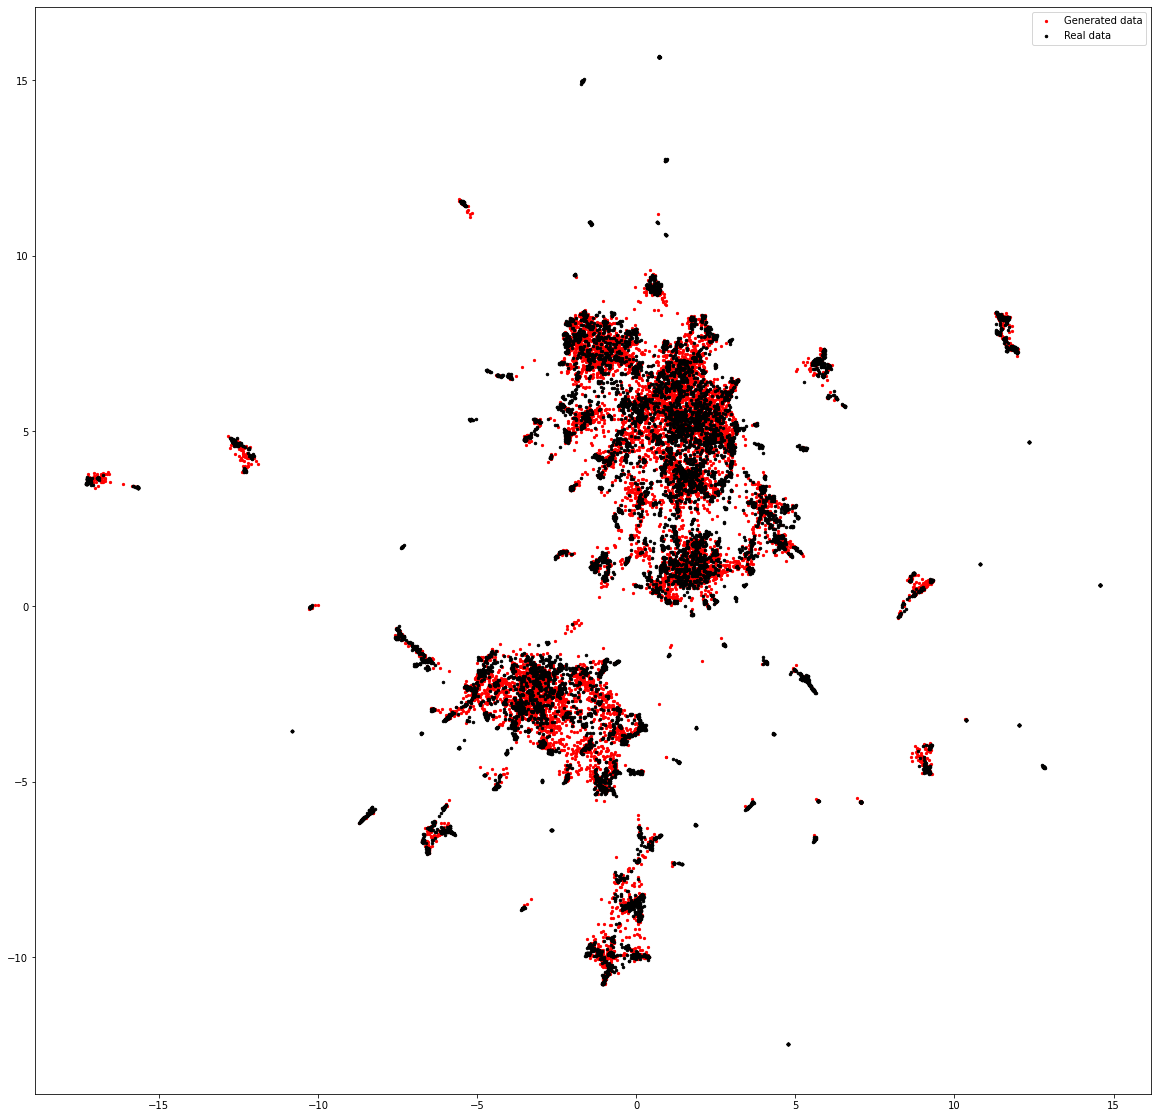

In [38]:
xumap=proj.transform(x)
gumap=proj.transform(s)
if comparetodata is not None:
    xcumap=proj.transform(xc)

plt.scatter(gumap[:,0],gumap[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcumap[:,0],xcumap[:,1], c='green',label='Other method')
plt.scatter(xumap[:,0],xumap[:,1], s=6, c='black',label='Real data')
plt.legend()

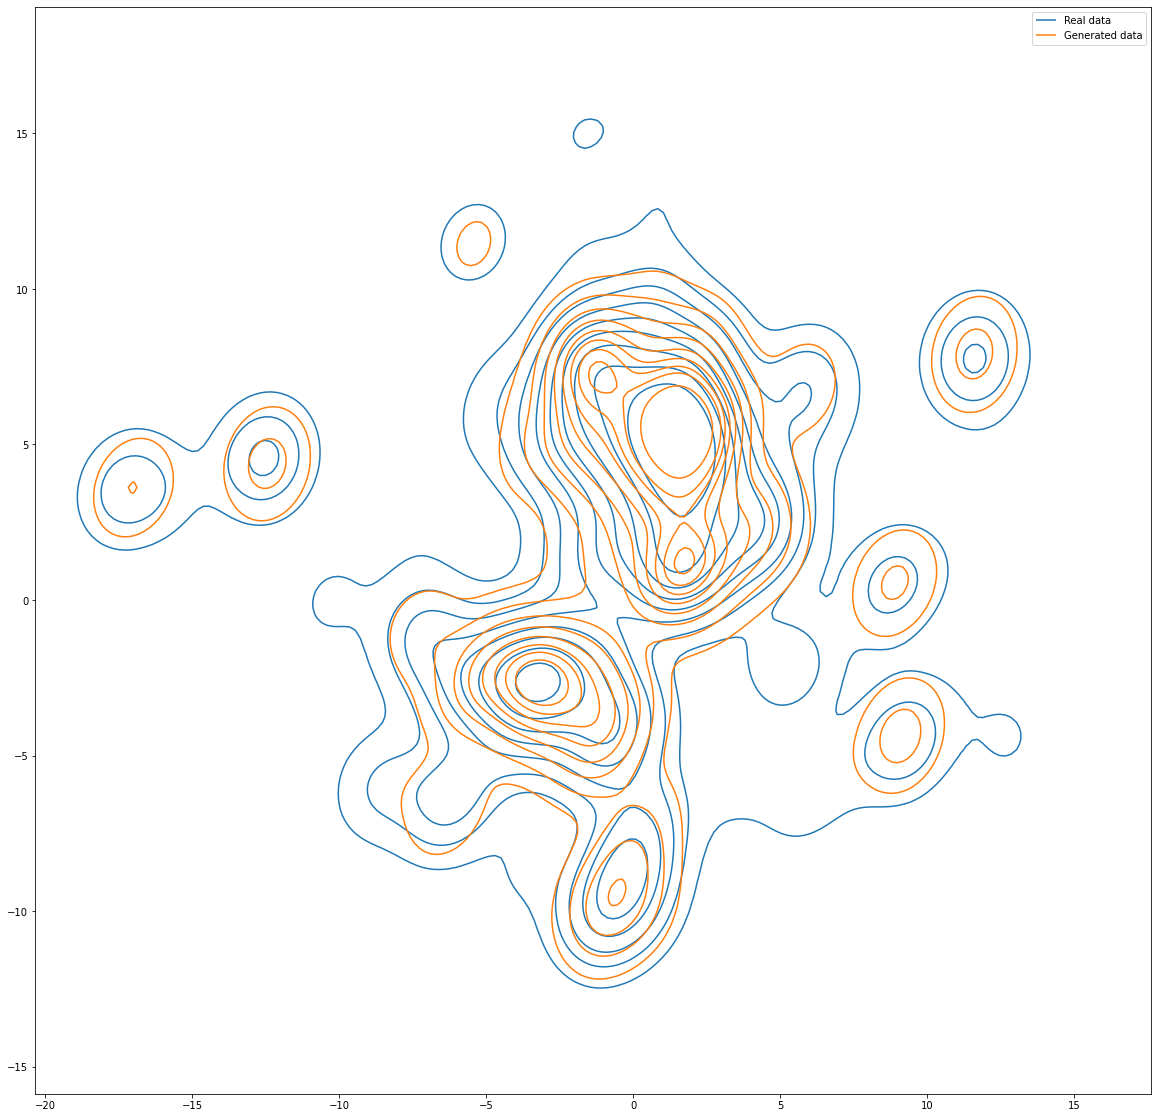

In [39]:
sns.kdeplot(x=xumap[:,0], y=xumap[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gumap[:,0], y=gumap[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()